# Analyse synthesis outputs

In [18]:
import numpy as np
from matplotlib import pyplot as plt
import glob
import optax

import scatcovjax.Sphere_lib as sphlib
from scatcovjax.Scattering_lib import scat_cov_axi, scat_cov_dir
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
import scatcovjax.plotting as plot


# Parameters

In [23]:
reality = True
sampling = 'mw'
multiresolution = True
L = 256
N = 3
epochs = 50
J_min = 0

J = s2wav.utils.shapes.j_max(L)
print(J)

axi = False
if N == 1:
    axi = True

8


# Make filters

(<Figure size 800x600 with 1 Axes>, <Axes: >)

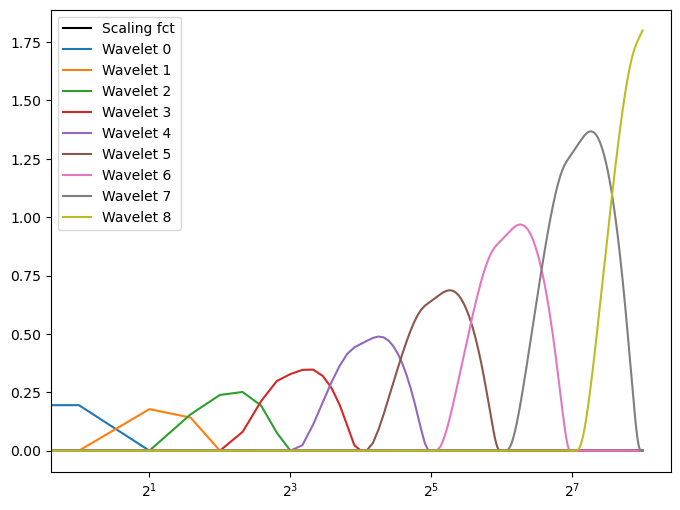

In [25]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=True, m=L-1)

# Load the data

In [14]:
# List of job with these parameters
job_list = glob.glob(f'../scripts/outputs/*L{L}_N{N}_epochs{epochs}')
print(job_list)

# Choose the run
run = 0
output_dir = job_list[run]

# flm
flm_initial = np.load(output_dir + '/initial_flm.npy')
flm_output = np.load(output_dir + '/output_flm.npy')
flm_target = np.load(output_dir + '/target_flm.npy')
loss_history = np.load(output_dir + '/loss.npy')
print(flm_initial.shape)

['../scripts/outputs/Job5982_L256_N3_epochs50']
(256, 511)


Text(0.5, 0, 'Number of iterations')

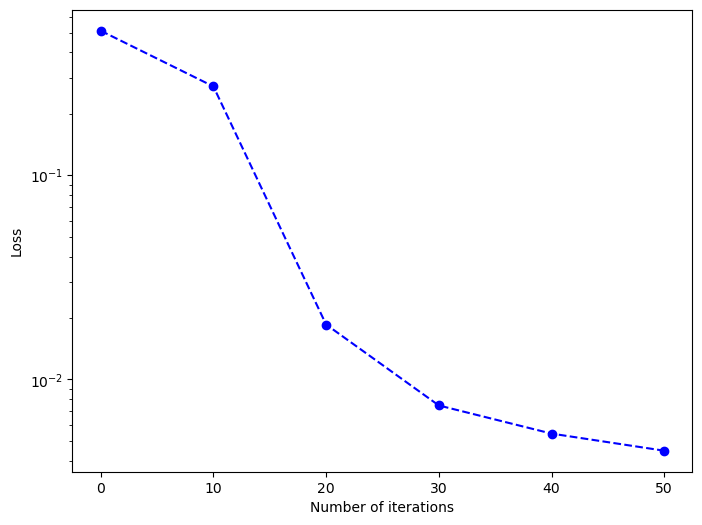

In [32]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 60, 10), loss_history, 'bo--')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')

In [16]:
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_initial = s2fft.inverse_jax(flm_initial, L, reality=reality)
f_output = s2fft.inverse_jax(flm_output, L, reality=reality)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


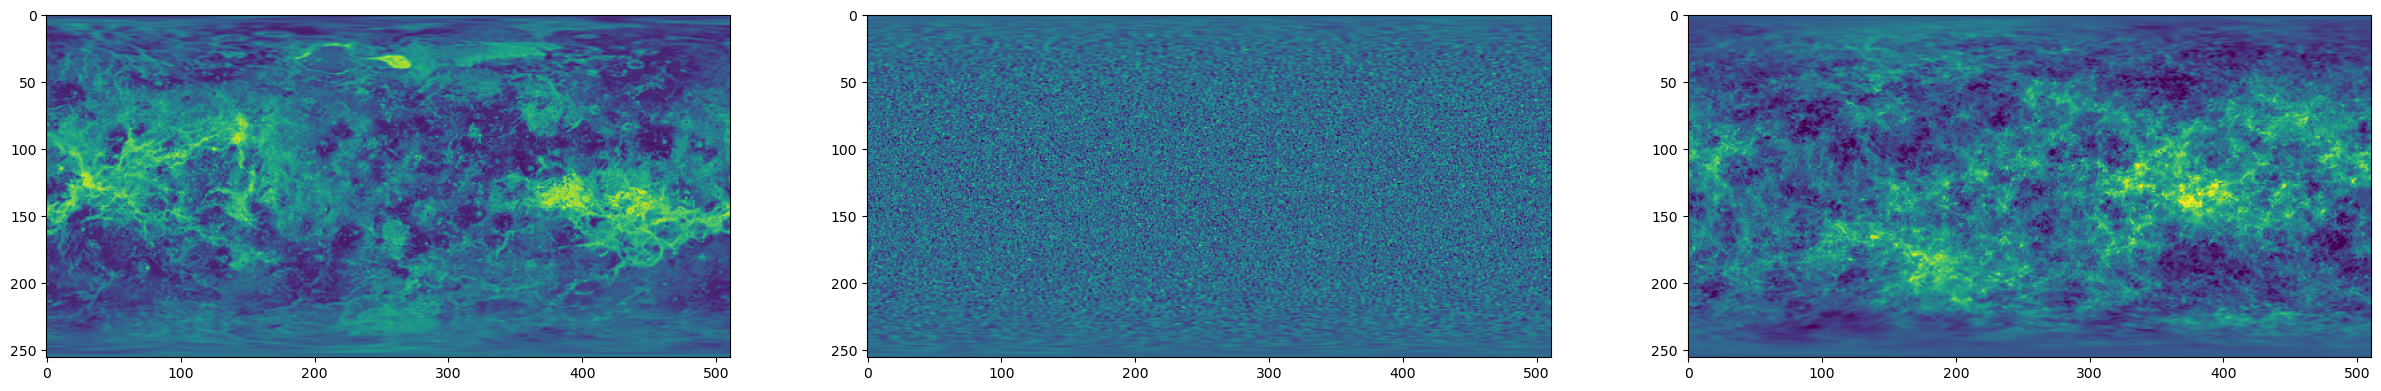

In [33]:
mx, mn = np.nanmax(f_target), np.nanmin(f_target)

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(30,10))
ax1.imshow(f_target, vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(f_initial, vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_output, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

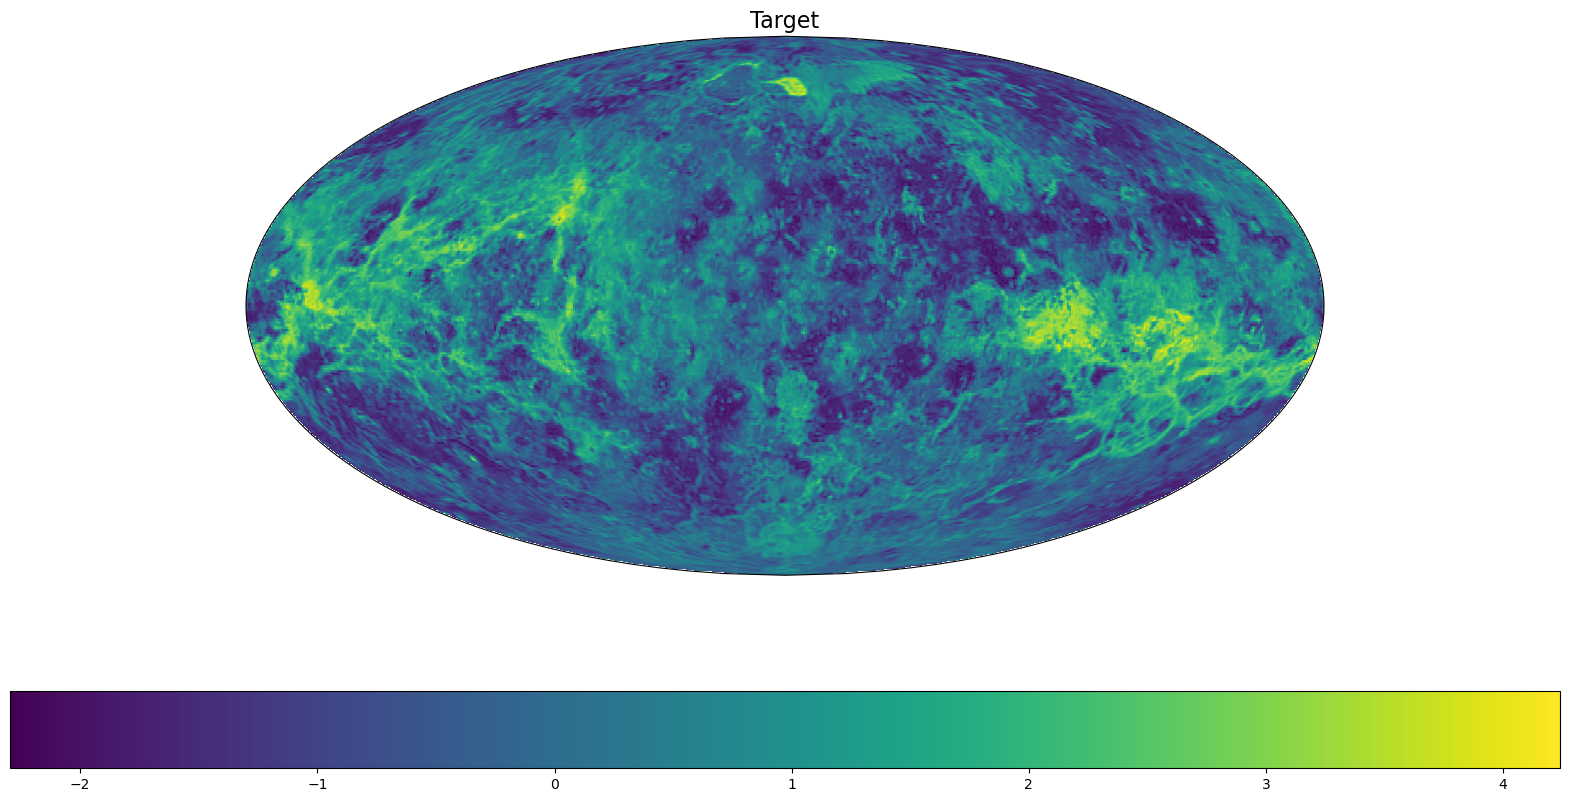

In [35]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title='Target', figsize=(20, 10))

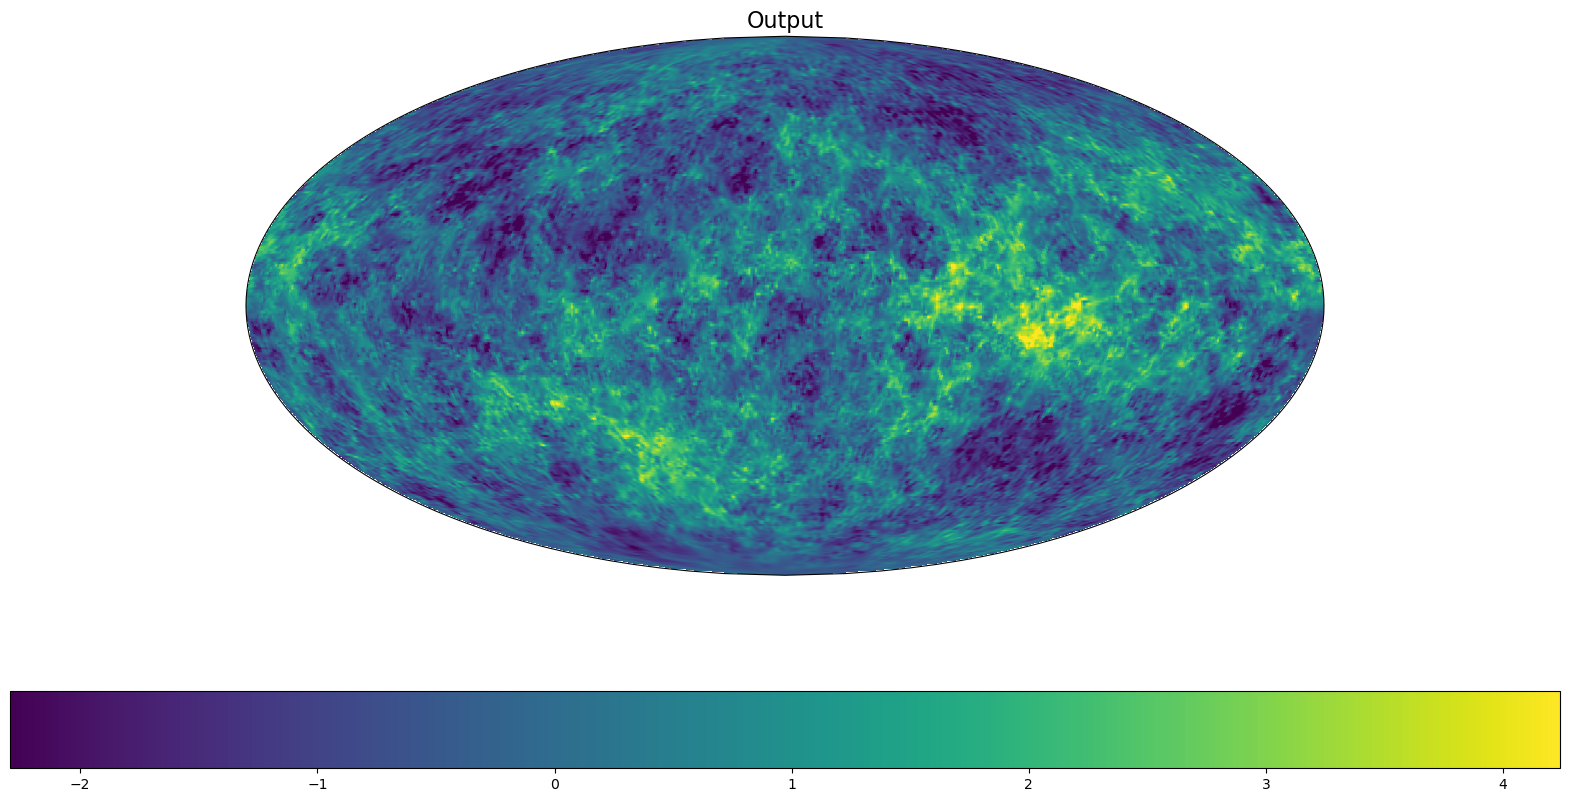

In [36]:
plot.plot_map_MW_Mollweide(f_output, vmin=mn, vmax=mx, title='Output', figsize=(20, 10))

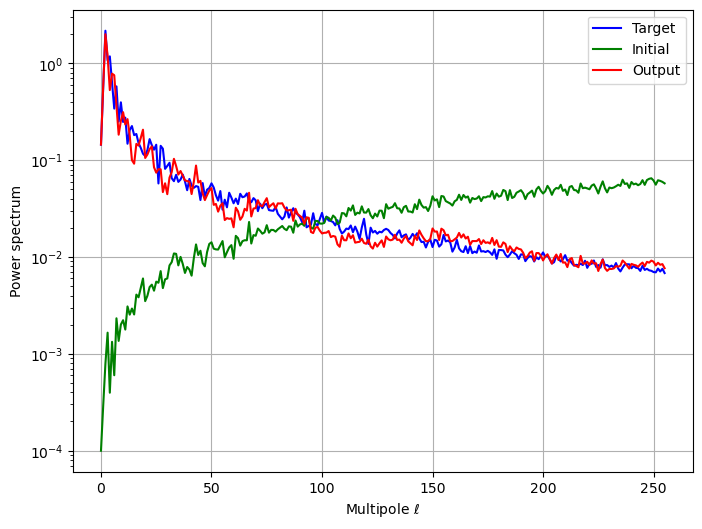

In [22]:
ps_target = sphlib.compute_ps(flm_target)
ps_initial = sphlib.compute_ps(flm_initial)
ps_output = sphlib.compute_ps(flm_output)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_initial, 'g', label="Initial")
plt.plot(ps_output, 'r', label="Output")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
plt.legend()

In [26]:
mean_target, var_target, S1_target, P00_target, C01_target, C11_target = scat_cov_axi(flm_target, L, N, J_min,
                                                                                      sampling, None,
                                                                                      reality=False,
                                                                                      multiresolution=multiresolution,
                                                                                      filters=filters)
mean_ini, var_ini, S1_ini, P00_ini, C01_ini, C11_ini = scat_cov_axi(flm_initial, L, N, J_min, sampling,
                                                                                None,
                                                                                reality=False,
                                                                                multiresolution=multiresolution,
                                                                                filters=filters)
mean_out, var_out, S1_out, P00_out, C01_out, C11_out = scat_cov_axi(flm_output, L, N, J_min, sampling, None,
                                                                    reality=False,
                                                                    multiresolution=multiresolution,
                                                                    filters=filters)


In [27]:
print('Mean:', mean_target, mean_ini, mean_out)
print('Var:', var_target, var_ini, var_out)

Mean: 0.10742234501760901 0.002815289097228932 0.10742234451767721
Var: 0.00011632300848300639 5.9821145734607706e-05 0.00010851518875298155


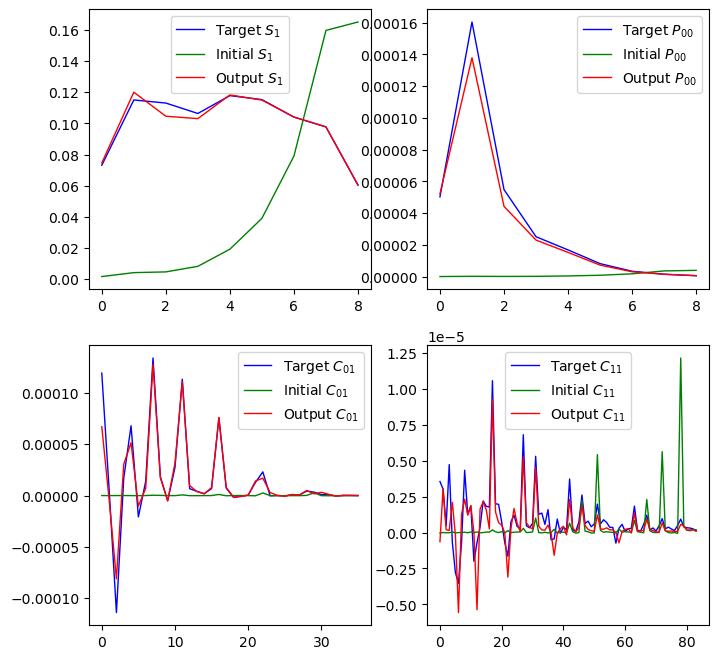

In [28]:
plot.plot_scatcov_coeffs(S1_target, P00_target, C01_target, C11_target, name='Target', hold=True, color='blue', lw=1)

plot.plot_scatcov_coeffs(S1_ini, P00_ini, C01_ini, C11_ini, name='Initial', hold=False, color='green', lw=1)

plot.plot_scatcov_coeffs(S1_out, P00_out, C01_out, C11_out, name='Output', hold=False, color='red', lw=1)